In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

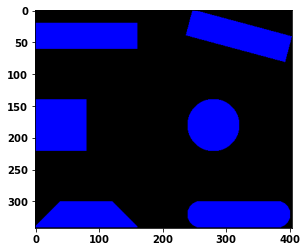

In [2]:
img_raw = cv.imread('basic_shapes.drawio.png', cv.IMREAD_COLOR)
img_gray = cv.cvtColor(img_raw, cv.COLOR_BGR2GRAY)
plt.imshow(img_raw);

len(contours)=6


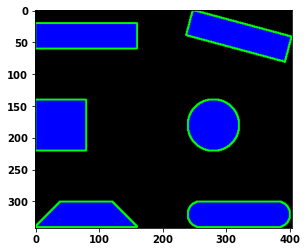

In [3]:

contours, _ = cv.findContours(img_gray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(f"{len(contours)=}")
img_draw = img_raw.copy()
cv.drawContours(img_draw, contours, -1, (0, 255, 0), 2)
plt.imshow(img_draw);

https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html

In [4]:
cdat = {"area": [], "perimeter": [], "cx": [], "cy": []}
for contour in contours:
    cdat["area"].append(cv.contourArea(contour))
    cdat["perimeter"].append(cv.arcLength(contour, True))
    mom = cv.moments(contour)
    cdat["cx"].append(int(mom['m10']/mom['m00']))
    cdat["cy"].append(int(mom['m01']/mom['m00']))


In [5]:
pd.DataFrame.from_dict(cdat)

,area,perimeter,cx,cy
0,6110.0,374.225396,320,320
1,4879.0,354.308655,80,322
2,5134.0,266.107648,280,180
3,6400.0,320.000000,40,180
4,6400.0,400.000000,80,40
5,6581.0,433.078208,319,40


# Draw bounting rectangle

((320.0, 320.0), (40.0, 160.0), 90.0)
((80.0, 320.0), (40.0, 160.0), 90.0)
((280.0, 180.0), (80.0, 80.0), 90.0)
((40.0, 180.0), (80.0, 80.0), 90.0)
((80.0, 40.0), (40.0, 160.0), 90.0)
((319.9791259765625, 39.9943962097168), (161.79995727539062, 41.88780975341797), 15.037816047668457)


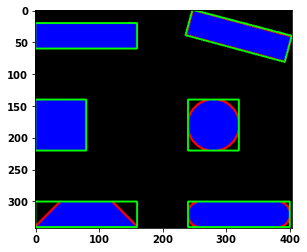

In [6]:
contours, _ = cv.findContours(img_gray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img_draw = img_raw.copy()
cv.drawContours(img_draw, contours, -1, (255, 0, 0), 2)

for contour in contours:
    rect = cv.minAreaRect(contour)
    print(rect)
    box = cv.boxPoints(rect)
    box = np.int0(box)
    cv.drawContours(img_draw,[box], 0, (0, 255, 0), 2)
plt.imshow(img_draw);

## Calculate Aspect ratio of the minimun bounding rectangle 
The aspect ratio is good for object recognition because it is invariant to ratation, scaling and shifting.

In [7]:
d = {"x": [], "y": [], "ar": [], "angle": []}
for contour in contours:
    rect = cv.minAreaRect(contour)
    (x, y), (h, w), angle = rect
    d["x"].append(x)
    d["y"].append(y)
    d["ar"].append(w/h)
    d["angle"].append(angle)
    
pd.DataFrame.from_dict(d)    

,x,y,ar,angle
0,320.000000,320.000000,4.000000,90.000000
1,80.000000,320.000000,4.000000,90.000000
2,280.000000,180.000000,1.000000,90.000000
3,40.000000,180.000000,1.000000,90.000000
4,80.000000,40.000000,4.000000,90.000000
5,319.979126,39.994396,0.258886,15.037816


## Try gasmeter image

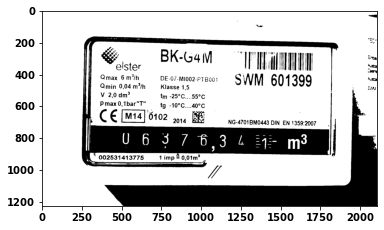

In [8]:
def bgr_2_gray(img):
    """ Converts a BGR image into a grayscale image based on blue and green, ignoring red 
    """
    return np.array(img[:,:,:2].mean(axis=2), dtype=np.uint8)

img_bgr = cv.imread('gas_sample.jpg', cv.IMREAD_COLOR)
img_gray = bgr_2_gray(img_bgr)

plt.imshow(img_raw, plt.cm.gray);

_, img_th = cv.threshold(img_gray, 0, 255, cv.THRESH_OTSU)
plt.imshow(img_th, plt.cm.gray);

len(contours)=698


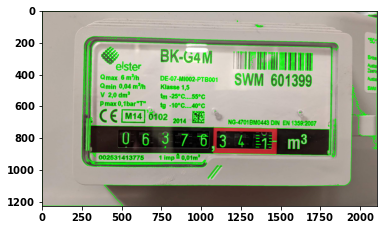

In [9]:
contours, _ = cv.findContours(img_th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(f"{len(contours)=}")
img_draw = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)  # opencv reads colors in BGR
cv.drawContours(img_draw, contours, -1, (0, 255, 0), 2)
plt.imshow(img_draw);

## Ignore irelevant tiny contours

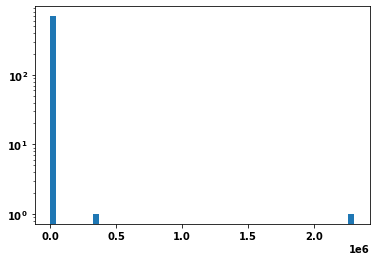

In [10]:
areas = [cv.contourArea(contour) for contour in contours]
plt.hist(areas, bins=50, )
plt.yscale('log');

In [11]:
len(contours)

698

In [12]:
big_contours = [c for c in contours if cv.contourArea(c) > 10e3]
len(big_contours)

3

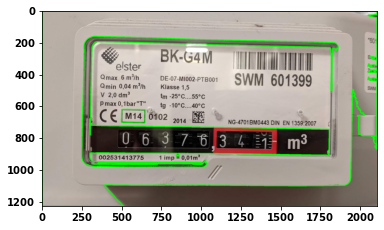

In [13]:
img_draw = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)  # opencv reads colors in BGR
cv.drawContours(img_draw, big_contours, -1, (0, 255, 0), 5)
plt.imshow(img_draw);

__Problem__: The black area isn't recognized as one contour!

Try fix thresholds!

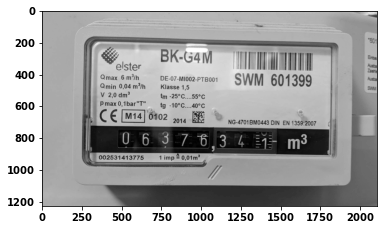

In [14]:
plt.imshow(img_gray, plt.cm.gray);

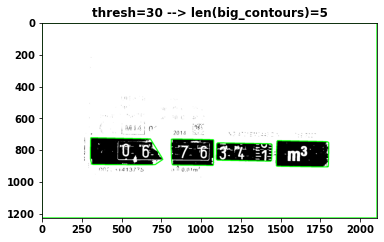

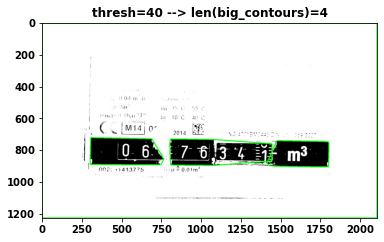

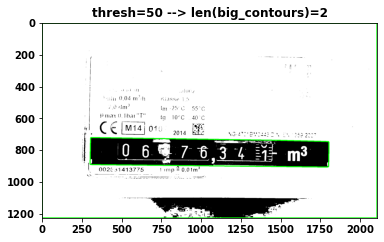

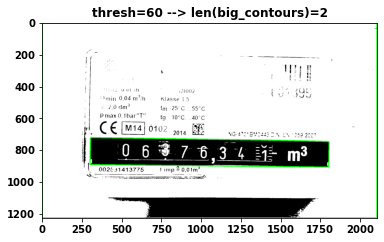

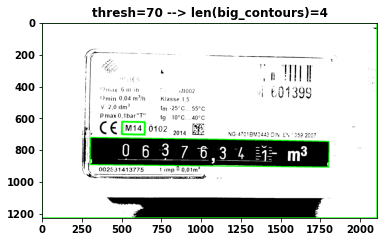

In [15]:
for thresh in [30, 40, 50, 60, 70]:
    _, img_th = cv.threshold(img_gray, thresh=thresh, maxval=255, type=cv.THRESH_BINARY)
    contours, _ = cv.findContours(img_th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    big_contours = [c for c in contours if cv.contourArea(c) > 10e3]
    convex_contours = [cv.convexHull(c) for c in big_contours]
    img_draw = cv.cvtColor(img_th, cv.COLOR_GRAY2RGB)  # opencv reads colors in BGR
    #img_draw = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
    #cv.drawContours(img_draw, big_contours, -1, (0, 255, 0), 5)
    cv.drawContours(img_draw, convex_contours, -1, (0, 255, 0), 5)
    plt.figure(), plt.imshow(img_draw);
    plt.title(f"{thresh=} --> {len(big_contours)=}")

In [16]:
cdat = {"area": [], "perimeter": [], "cx": [], "cy": []}
for contour in convex_contours:
    cdat["area"].append(cv.contourArea(contour))
    cdat["perimeter"].append(cv.arcLength(contour, True))
    mom = cv.moments(contour)
    cdat["cx"].append(int(mom['m10']/mom['m00']))
    cdat["cy"].append(int(mom['m01']/mom['m00']))
pd.DataFrame.from_dict(cdat)

,area,perimeter,cx,cy
0,2581075.0,6664.000000,1053,612
1,251499.0,3329.458852,1047,813
2,12359.5,456.064707,574,660
3,10253.5,419.805246,574,660


In [17]:
contour = convex_contours[1]
minRect = cv.minAreaRect(contour)
(x, y), (h, w), angle = minRect
aspect_ratio = max(h/w, w/h)
aspect_ratio

8.785274996328313

In [25]:
cv.contourArea(contour) / (h*w)

0.9788859690517697

In [18]:
h*w

256923.6948442757

In [19]:
minRextBox = np.int0(cv.boxPoints(minRect))
    #cv.drawContours(img_draw,[box], 0, (0, 255, 0), 2)
minRextBox


array([[ 301,  889],
       [ 304,  718],
       [1806,  740],
       [1804,  911]], dtype=int64)

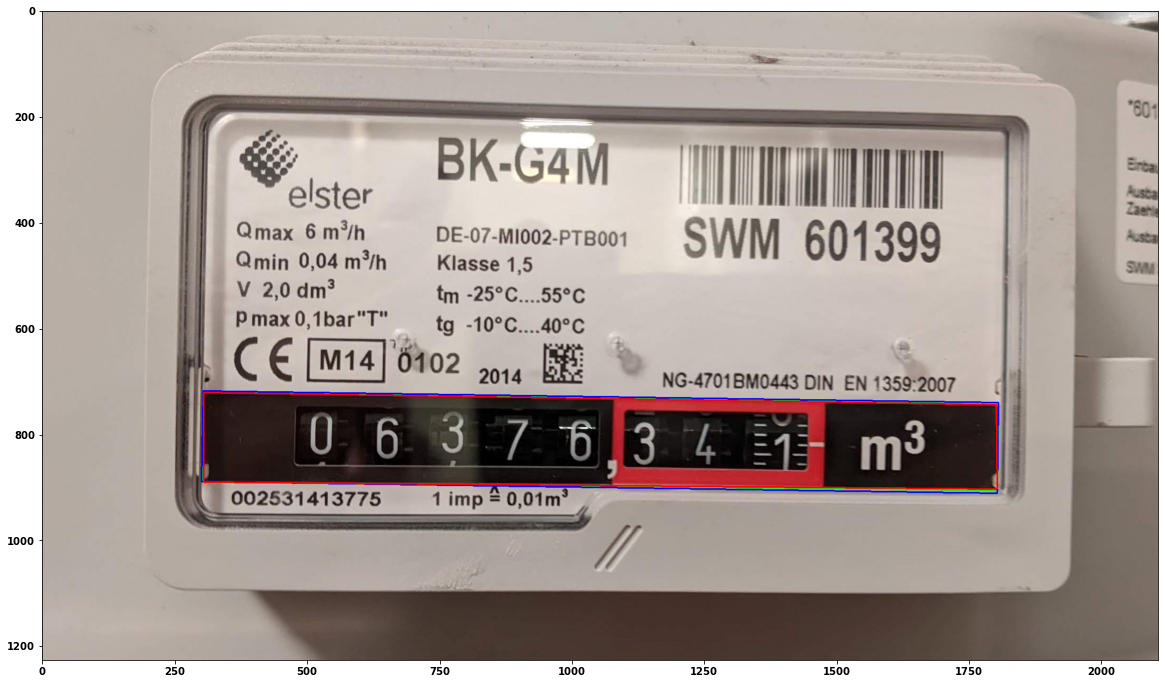

In [20]:
img_draw = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
cv.drawContours(img_draw, [contour], -1, (0, 255, 0), 2)
cv.drawContours(img_draw, [minRextBox], -1, (0, 0, 255), 2)
apx = cv.approxPolyDP(contour, 0.003 * cv.arcLength(contour, True), True)
cv.drawContours(img_draw, [apx], -1, (255, 0, 0), 2)
plt.figure(figsize=(20, 19)), plt.imshow(img_draw);

In [26]:
for fract in np.logspace(-1, -3, 10):
    apx = cv.approxPolyDP(contour, fract * cv.arcLength(contour, True), True)
    print(f"{fract= :.1e}\t{len(apx)=}")

fract= 1.0e-01	len(apx)=2
fract= 6.0e-02	len(apx)=2
fract= 3.6e-02	len(apx)=4
fract= 2.2e-02	len(apx)=4
fract= 1.3e-02	len(apx)=4
fract= 7.7e-03	len(apx)=4
fract= 4.6e-03	len(apx)=4
fract= 2.8e-03	len(apx)=4
fract= 1.7e-03	len(apx)=4
fract= 1.0e-03	len(apx)=5
